In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
total_returns_all = pd.read_excel('spx_returns_weekly.xlsx', 's&p500 rets')

total_returns = total_returns_all[['date', 'AAPL', 'META', 'NVDA', 'TSLA']]

#1.1 - Volatility, VaR, and CVaR
sample_statistics = pd.DataFrame({
    'Volatility': total_returns.std(),
    'Volatility (annualized)': total_returns.std() * np.sqrt(52),
    'VaR': total_returns.quantile(0.05),
    'CVaR': total_returns[total_returns < total_returns.quantile(0.05)].mean()
}).iloc[1:]

sample_statistics

,Volatility,Volatility (annualized),VaR,CVaR
AAPL,0.038362,0.276629,-0.056366,-0.083125
META,0.048722,0.351336,-0.070012,-0.103196
NVDA,0.064246,0.463283,-0.086853,-0.116455
TSLA,0.081323,0.586431,-0.117397,-0.147814


In [3]:
#1.2 - Form an Equally Weighted Portfolio of the Investments
weights_ew = np.array([1/4] * 4)
total_returns['ew_return'] = total_returns.iloc[:, 1:5].dot(weights_ew)
fifth_quantile_ew = total_returns['ew_return'].quantile(0.05)

sample_statistics.loc['portfolio_ew'] = [
    total_returns['ew_return'].std(),
    total_returns['ew_return'].std() * np.sqrt(52),
    fifth_quantile_ew,
    total_returns['ew_return'][total_returns['ew_return'] < fifth_quantile_ew].mean()
    ]

display(sample_statistics)

print("We find that the volatility is on the lower end, but it is not as low as AAPL.\nThe VaR is also not as bad as individual stocks, besides AAPL, and this is consistent with CVaR as well.")

print("This means that the diversification has not fully worked yet.")

,Volatility,Volatility (annualized),VaR,CVaR
AAPL,0.038362,0.276629,-0.056366,-0.083125
META,0.048722,0.351336,-0.070012,-0.103196
NVDA,0.064246,0.463283,-0.086853,-0.116455
TSLA,0.081323,0.586431,-0.117397,-0.147814
portfolio_ew,0.043758,0.315543,-0.06195,-0.084992


We find that the volatility is on the lower end, but it is not as low as AAPL.
The VaR is also not as bad as individual stocks, besides AAPL, and this is consistent with CVaR as well.
This means that the diversification has not fully worked yet.


In [4]:
#1.3 - Drop the most volatile asset and replace it with a zero-RF rate

#The most volatile asset is TSLA, so we can simply drop this.

weights_without_most_volatile = np.array([1/4, 1/4, 1/4])
total_returns['ew_return_noTSLA'] = total_returns.iloc[:, 1:4].dot(weights_without_most_volatile)
fifth_quantile_ew = total_returns['ew_return_noTSLA'].quantile(0.05)

sample_statistics.loc['portfolio_ew_noTSLA'] = [
    total_returns['ew_return_noTSLA'].std(),
    total_returns['ew_return_noTSLA'].std() * np.sqrt(52),
    fifth_quantile_ew,
    total_returns['ew_return_noTSLA'][total_returns['ew_return_noTSLA'] < fifth_quantile_ew].mean()
    ]

display(sample_statistics)
print(f"The most volatile asset was adding {sample_statistics['Volatility (annualized)'][-2] - sample_statistics['Volatility (annualized)'][-1]} risk (annualized volatility) to the total portfolio.")

#To compute volatility added to portfolio, we can use the formula {Vol_added_i = w_i * Cov(ret_i, ret_port)/vol(portfolio)}

print(f"This is slightly less than the stand-alone risk, which makes sense due to diversification, since {0.25 * total_returns['ew_return'].cov(total_returns['TSLA']) * 52/sample_statistics['Volatility (annualized)'][-1]} < {sample_statistics['Volatility (annualized)'][-3]}")

,Volatility,Volatility (annualized),VaR,CVaR
AAPL,0.038362,0.276629,-0.056366,-0.083125
META,0.048722,0.351336,-0.070012,-0.103196
NVDA,0.064246,0.463283,-0.086853,-0.116455
TSLA,0.081323,0.586431,-0.117397,-0.147814
portfolio_ew,0.043758,0.315543,-0.06195,-0.084992
portfolio_ew_noTSLA,0.030282,0.218365,-0.042463,-0.060531


The most volatile asset was adding 0.09717795530333626 risk (annualized volatility) to the total portfolio.
This is slightly less than the stand-alone risk, which makes sense due to diversification, since 0.1680167631087005 < 0.5864312688223826


In [5]:
#2.1 - Dynamic Measures - Rolling volatility
squared = total_returns[['AAPL', 'META', 'NVDA', 'TSLA']]**2

#Rolling Volatility window
rolling_volatility_series = pd.DataFrame({})
rolling_volatility_series['date'] = total_returns['date']
rolling_volatility_series = pd.concat([rolling_volatility_series, (squared.shift(1).rolling(window = 26, min_periods = 1).mean())**(1/2)], axis = 1)
print("Rolling Volatility Series")
display(rolling_volatility_series)

#Calculate normal VaR and normal CVaR at the end of sample with time period 1 week

#VaR = z_0.05 * rolling_vol
normal_vars = rolling_volatility_series.iloc[-1, 1:] * -1.65

#CVaR = Expected value of the truncated normal distribution = -f(VaR)/0.05 * rolling_vol
def f(x):
    return 1/(2*np.pi)**(1/2) * np.exp(-1/2 * x**2)

normal_cvars = -f(-1.65) * rolling_volatility_series.iloc[-1, 1:] / 0.05

normal_statistics = pd.DataFrame({
    'VaR':  normal_vars,
    'CVaR': normal_cvars
})
display(normal_statistics)
print("\nThe normal VaR and CVaR are in line with the historical Value-at-Risk. However, they slightly overestimate the historical Value at Risk every time. Here is a comparison of the error between them:")
display((sample_statistics[['VaR', 'CVaR']] - normal_statistics).head(4))

Rolling Volatility Series


,date,AAPL,META,NVDA,TSLA
0,2015-01-09,NaN,NaN,NaN,NaN
1,2015-01-16,0.024514,0.009055,0.009315,0.057685
2,2015-01-23,0.041770,0.024150,0.006613,0.061855
3,2015-01-30,0.051117,0.028339,0.022358,0.056168
4,2015-02-06,0.047978,0.027468,0.041157,0.048981
...,...,...,...,...,...
537,2025-04-25,0.045568,0.050696,0.075278,0.099065
538,2025-05-02,0.047089,0.053755,0.077330,0.095975
539,2025-05-09,0.046681,0.056596,0.077107,0.094851
540,2025-05-16,0.046981,0.056093,0.075135,0.076262


,VaR,CVaR
AAPL,-0.080317,-0.099558
META,-0.094204,-0.116773
NVDA,-0.133871,-0.165943
TSLA,-0.137775,-0.170783



The normal VaR and CVaR are in line with the historical Value-at-Risk. However, they slightly overestimate the historical Value at Risk every time. Here is a comparison of the error between them:


,VaR,CVaR
AAPL,0.02395,0.016433
META,0.024192,0.013577
NVDA,0.047018,0.049487
TSLA,0.020378,0.022969


In [6]:
#Hit Test
#Expanding Volatility
expanding_volatility_series = pd.DataFrame({})
expanding_volatility_series['date'] = total_returns['date']
expanding_volatility_series = pd.concat([expanding_volatility_series, (squared.shift(1).expanding(min_periods = 1).mean())**(1/2)], axis = 1)
print("Expanding Volatility Series:")
display(expanding_volatility_series)

historical_var_series = pd.DataFrame({})
historical_var_series['date'] = total_returns['date']
historical_var_series = pd.concat([historical_var_series, total_returns[['AAPL', 'META', 'NVDA', 'TSLA']].shift(1).expanding(min_periods = 1).quantile(0.05)], axis = 1)
print("Historical 5th Quantile:")
display(historical_var_series)

Expanding Volatility Series:


,date,AAPL,META,NVDA,TSLA
0,2015-01-09,NaN,NaN,NaN,NaN
1,2015-01-16,0.024514,0.009055,0.009315,0.057685
2,2015-01-23,0.041770,0.024150,0.006613,0.061855
3,2015-01-30,0.051117,0.028339,0.022358,0.056168
4,2015-02-06,0.047978,0.027468,0.041157,0.048981
...,...,...,...,...,...
537,2025-04-25,0.038408,0.048715,0.065155,0.081387
538,2025-05-02,0.038467,0.048828,0.065220,0.081683
539,2025-05-09,0.038440,0.048940,0.065173,0.081608
540,2025-05-16,0.038431,0.048896,0.065118,0.081549


Historical 5th Quantile:


,date,AAPL,META,NVDA,TSLA
0,2015-01-09,NaN,NaN,NaN,NaN
1,2015-01-16,0.024514,-0.009055,-0.009315,-0.057685
2,2015-01-23,-0.049832,-0.031737,-0.008807,-0.065357
3,2015-01-30,-0.045919,-0.030543,-0.008300,-0.064953
4,2015-02-06,-0.042007,-0.031691,-0.063138,-0.064549
...,...,...,...,...,...
537,2025-04-25,-0.054350,-0.070454,-0.087003,-0.117734
538,2025-05-02,-0.054216,-0.070350,-0.086971,-0.117659
539,2025-05-09,-0.054082,-0.070247,-0.086939,-0.117583
540,2025-05-16,-0.053947,-0.070143,-0.086907,-0.117508


In [7]:
#Calculate VaR for rolling and expanding volatilities
cols = ['AAPL', 'META', 'NVDA', 'TSLA']
normal_vars_rolling = rolling_volatility_series
normal_vars_rolling[cols] = normal_vars_rolling[cols] * -1.65

normal_vars_expanding = expanding_volatility_series
normal_vars_expanding[cols] = normal_vars_expanding[cols] * -1.65


In [8]:
#Rolling "hits"
total_hits_rolling = (total_returns[cols] < normal_vars_rolling[cols]).sum()/len(total_returns)
total_hits_expanding = (total_returns[cols] < normal_vars_expanding[cols]).sum()/len(total_returns)
total_hits_historical = (total_returns[cols] < historical_var_series[cols]).sum()/len(total_returns)



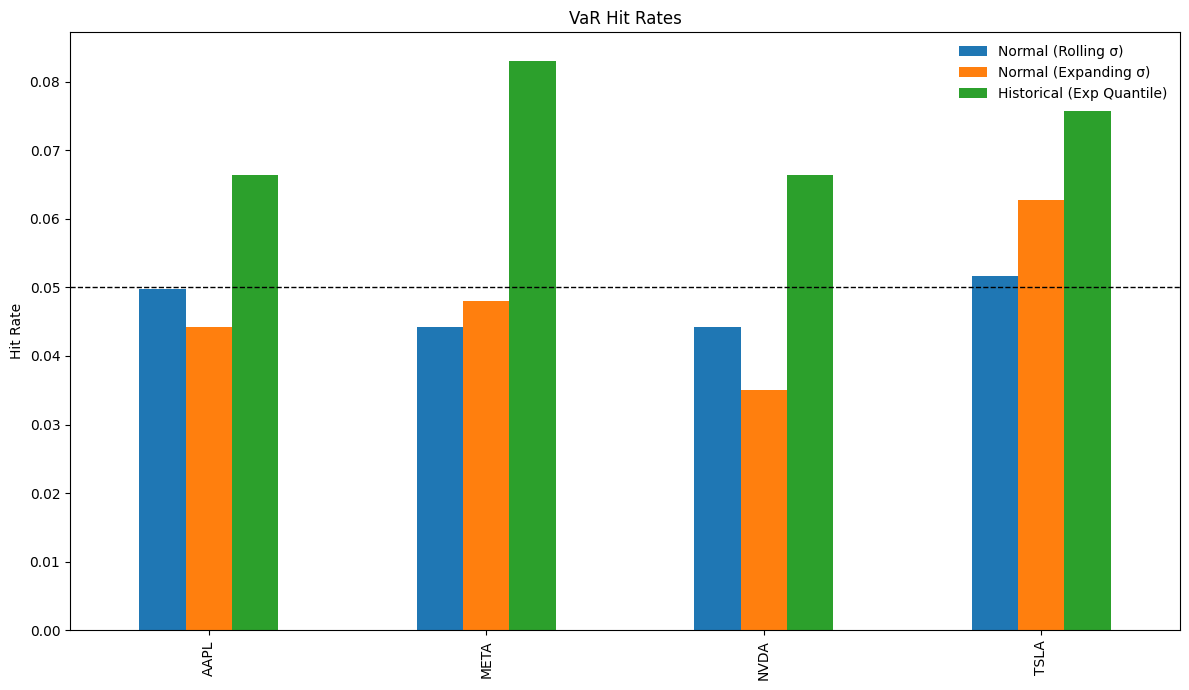

In [9]:
hits_df = pd.DataFrame({
    "Normal (Rolling σ)":   total_hits_rolling,
    "Normal (Expanding σ)": total_hits_expanding,
    "Historical (Exp Quantile)": total_hits_historical,
})

#Plot Hit count

fig, ax = plt.subplots(figsize=(12,7))
hits_df.plot(kind="bar", ax=ax)
ax.axhline(0.05, ls="--", color="k", linewidth=1)
ax.set_title("VaR Hit Rates")
ax.set_ylabel("Hit Rate")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

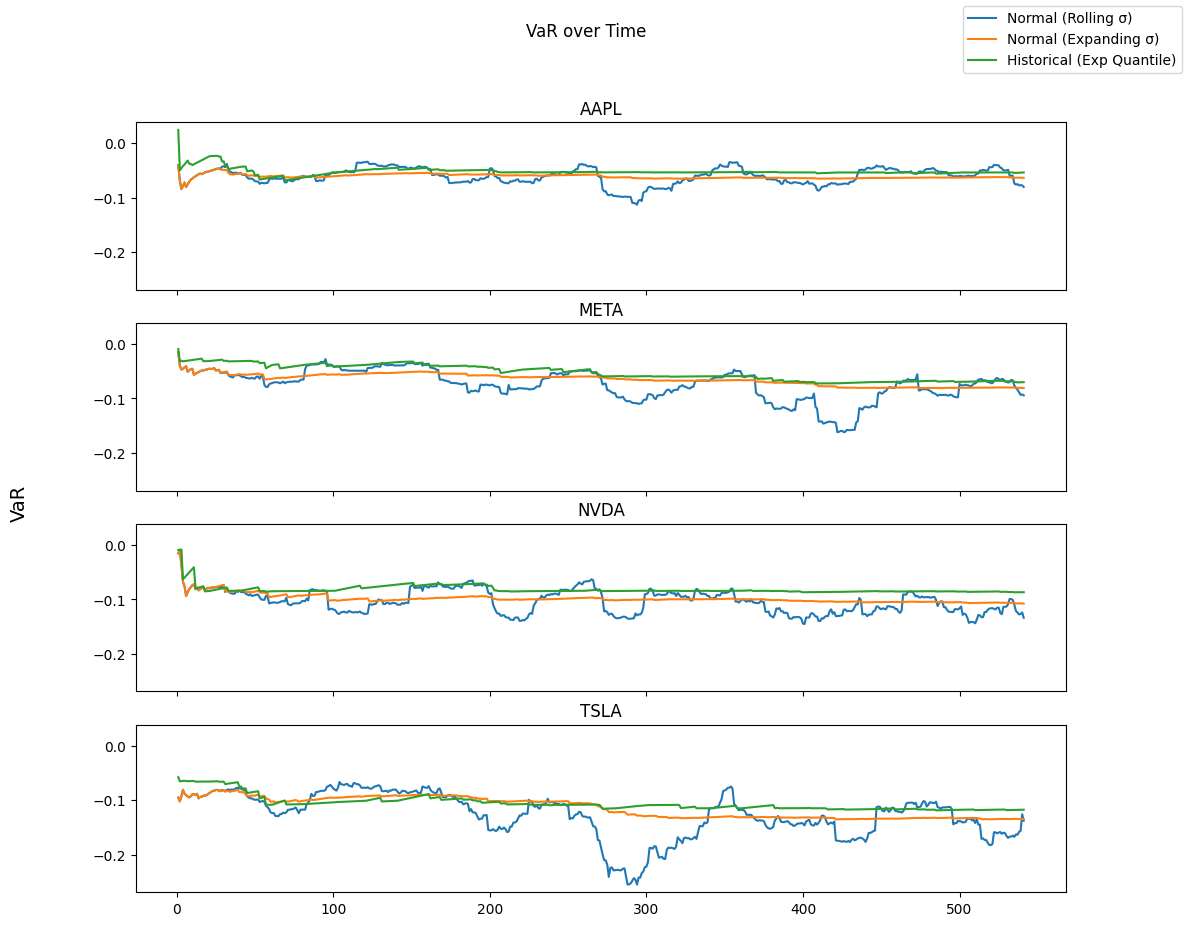

In [28]:
#Plotting VaR over time

fig, ax = plt.subplots(4, 1, figsize = (12, 10), sharex = True, sharey = True)
for i, ticker in enumerate(cols):
    ax[i].plot(normal_vars_rolling.index, normal_vars_rolling[ticker], label = 'Normal (Rolling σ)')
    ax[i].plot(normal_vars_expanding.index, normal_vars_expanding[ticker], label = 'Normal (Expanding σ)')
    ax[i].plot(historical_var_series.index, historical_var_series[ticker], label = 'Historical (Exp Quantile)')
    ax[i].set_title(f'{ticker}')

fig.supylabel("VaR", fontsize=14, ha='left')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes][:1]
lines, labels = [sum(_, []) for _ in zip(*lines_labels)]
fig.legend(lines, labels)
plt.suptitle('VaR over Time')
plt.show()